# Estimating COVID-19's $R_t$ in Real-Time

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will reduce quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety.

It is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) granularity of $R_t$.

The solution is a modified version of a solution created by Bettencourt & Ribeiro 2008 to estimate real-time $R_t$ using a Bayesian approach. This model tries to estimate a time-varying $R_t$.

### Imports

In [21]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats as sps
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'

In [22]:
headers = {'Content-Type': 'application/json'}

# url from where statewise time series data is fetched 
api_url = 'https://api.rootnet.in/covid19-in/stats/history'
response = requests.get(api_url, headers=headers)
jsonObject = {}
if response.status_code == 200:
    jsonObject =  json.loads(response.content.decode('utf-8'))
data = jsonObject['data']

In [23]:
def check_state_name(s):
    if s == 'Telengana':
        return 'Telangana'
    elif s[-1] == '#':
        return s[:-1]
    else:
        return s

In [24]:
cols = ['date','state','confirmed']
df_statewise_timeseries = pd.DataFrame(data=None,columns=cols)

In [25]:
# We try and form a dataframe which containes the timeseries data for each state
for i in data:
    date = i['day']
    regional = i['regional']
    for j in regional:
        state = check_state_name(j['loc'])
        confirmed = int(j['totalConfirmed']) + 0.0
        df_row = pd.DataFrame(data = [[date,state,confirmed]],columns=cols)
        df_statewise_timeseries = df_statewise_timeseries.append(df_row)
df_statewise_timeseries.head()

,date,state,confirmed
0,2020-03-10,Delhi,4.0
0,2020-03-10,Haryana,14.0
0,2020-03-10,Karnataka,1.0
0,2020-03-10,Kerala,9.0
0,2020-03-10,Maharashtra,2.0


In [26]:
arr = df_statewise_timeseries['state'].unique()
arr

array(['Delhi', 'Haryana', 'Karnataka', 'Kerala', 'Maharashtra', 'Punjab',
       'Rajasthan', 'Tamil Nadu', 'Telangana', 'Jammu and Kashmir',
       'Ladakh', 'Uttar Pradesh', 'Andhra Pradesh', 'Uttarakhand',
       'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
       'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
       'Goa', 'Assam', 'Jharkhand', 'Arunachal Pradesh', 'Tripura',
       'Nagaland', 'Meghalaya', 'Dadar Nagar Haveli'], dtype=object)

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$.

Bayes' rule is used to update the true value of $R_t$ based on how many new cases have been reported each day.

Bayes' Theorem

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

What this means is that ,having seen $k$ new cases, the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times 
- The __prior__ beliefs of the value of $P(R_t)$ without the data 
- divided by the probability of seeing this many cases in general.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [27]:
# Here we assume a maximum possible value for Rt.
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
GAMMA = 1/7

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update) to get the posteriors. 

### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [28]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors,log_likelihood

### A function for calculating the highest possible and lowest possible values can take on a day given a posterior

In [29]:
def highest_density_interval(pmf, p=.9, debug=False):
   
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

### A function to plot our findings as an area graph between Max and Min value of Rt and also the most likely value of Rt

In [30]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

### A driver function to find realtime Rt and plot the grpah for all states

In [31]:
def getR0(state):

    confirmed = df_statewise_timeseries[df_statewise_timeseries['state'] == state]['confirmed'].to_numpy()

    dates = df_statewise_timeseries[df_statewise_timeseries['state'] == state]['date'].to_numpy()
    dates = pd.to_datetime(dates,infer_datetime_format=True)

    s1 = pd.DataFrame(data={'date' : dates,'confirmed':confirmed})
    s1 = s1.set_index('date')

    smoothed = s1['confirmed'].infer_objects()
    smoothed = smoothed.rename(state + ' cases')

    posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

    hdis = highest_density_interval(posteriors, p=.9)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    
    fig, ax = plt.subplots(figsize=(600/72,400/72))

    plot_rt(result, ax, state)
    ax.set_title(f'Real-time $R_t$ for {state}')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    fig.set_facecolor('w')

/home/akash/.local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/akash/.local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


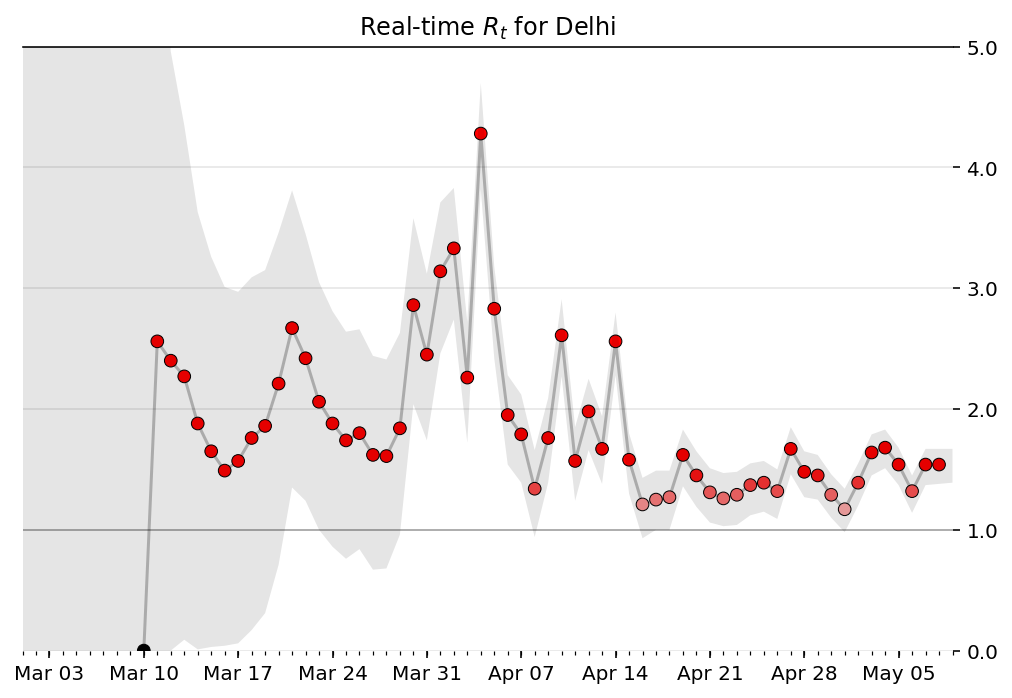

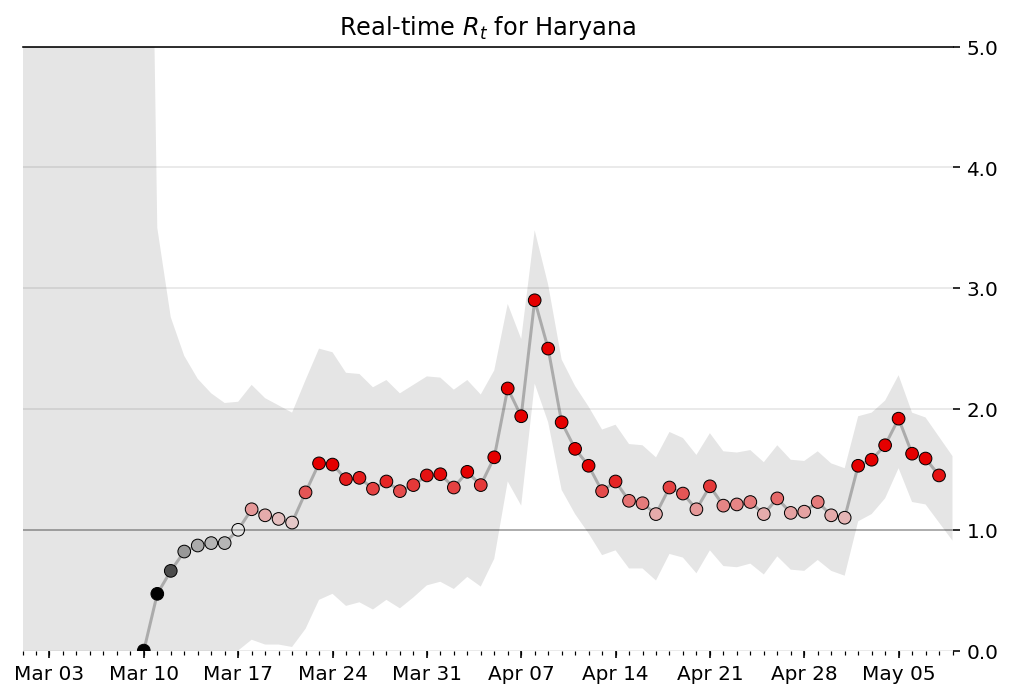

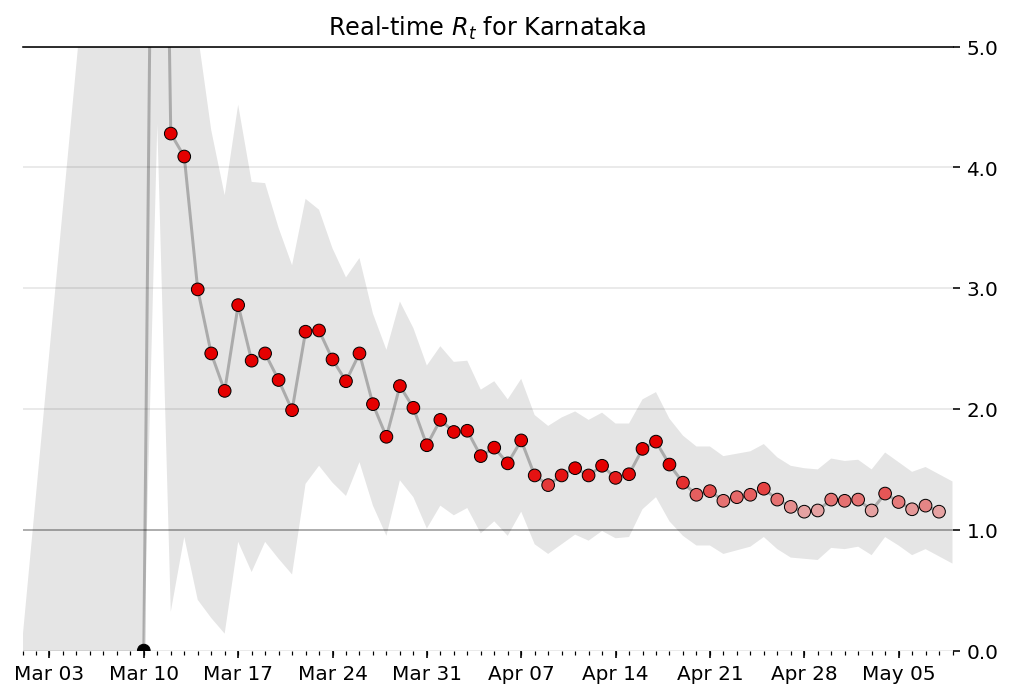

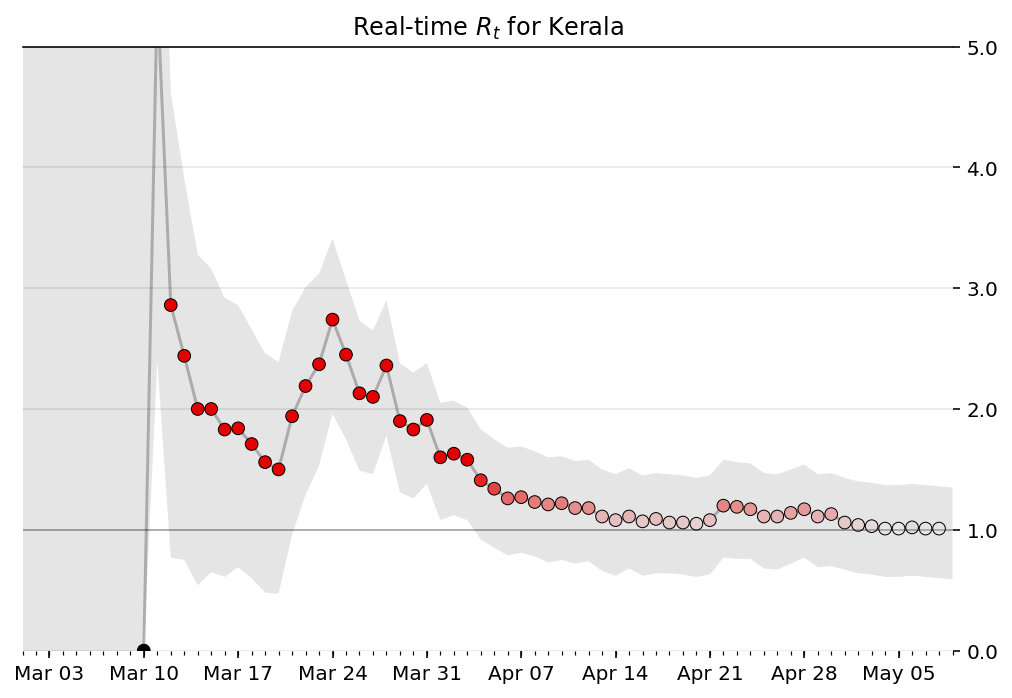

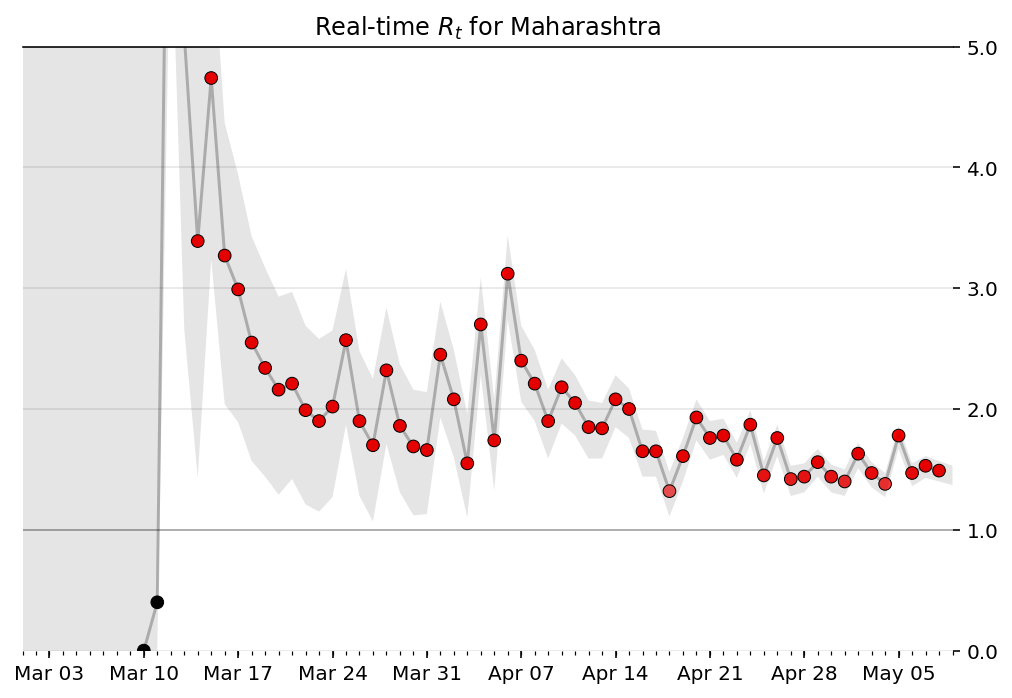

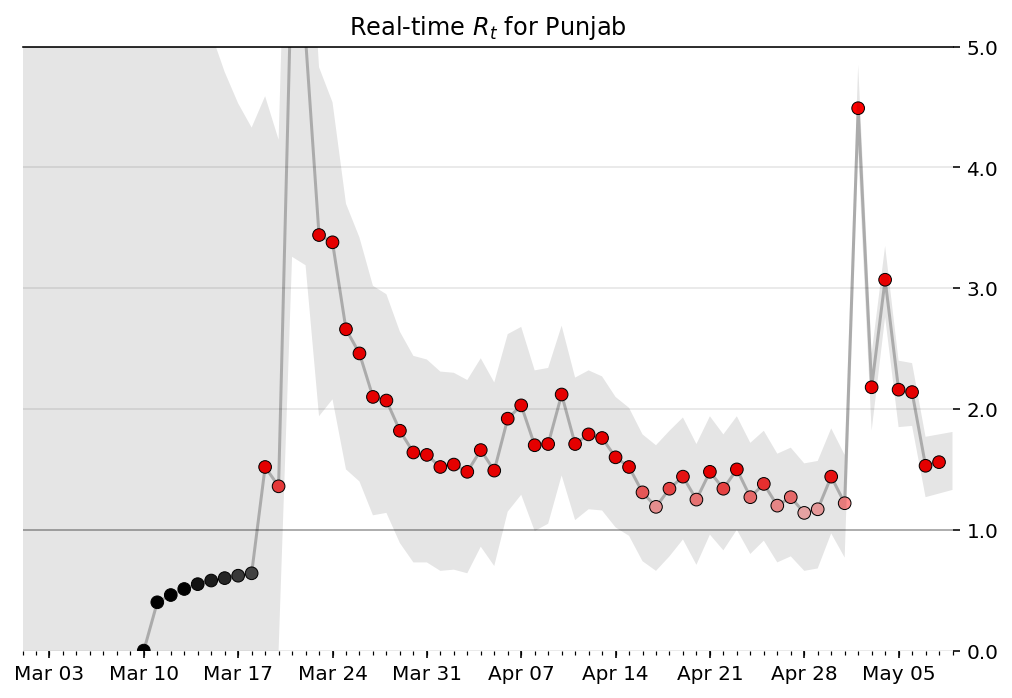

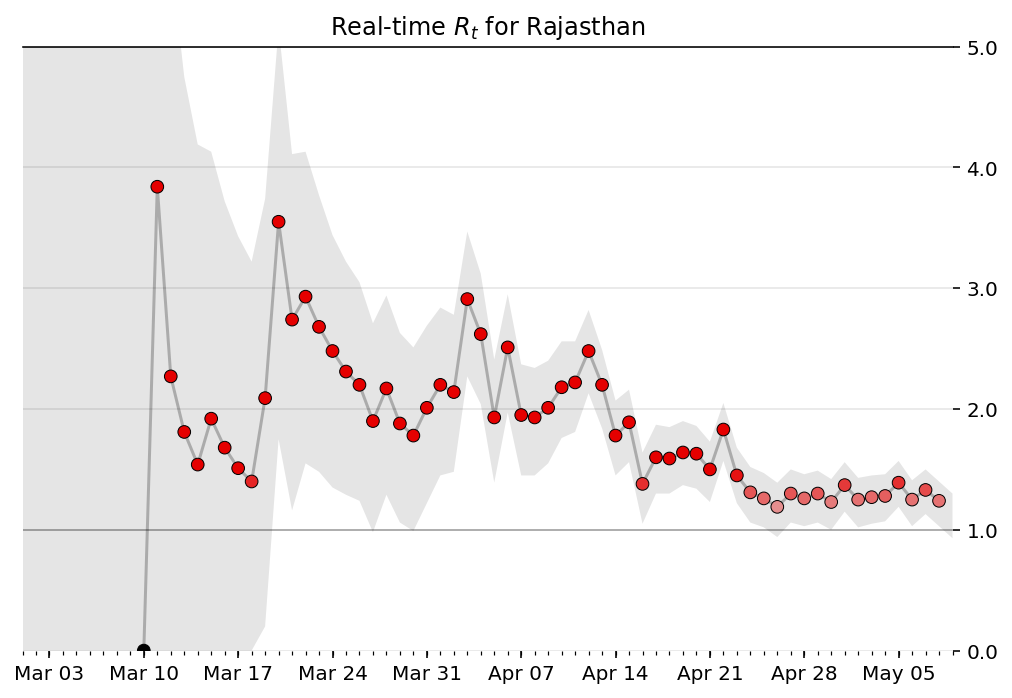

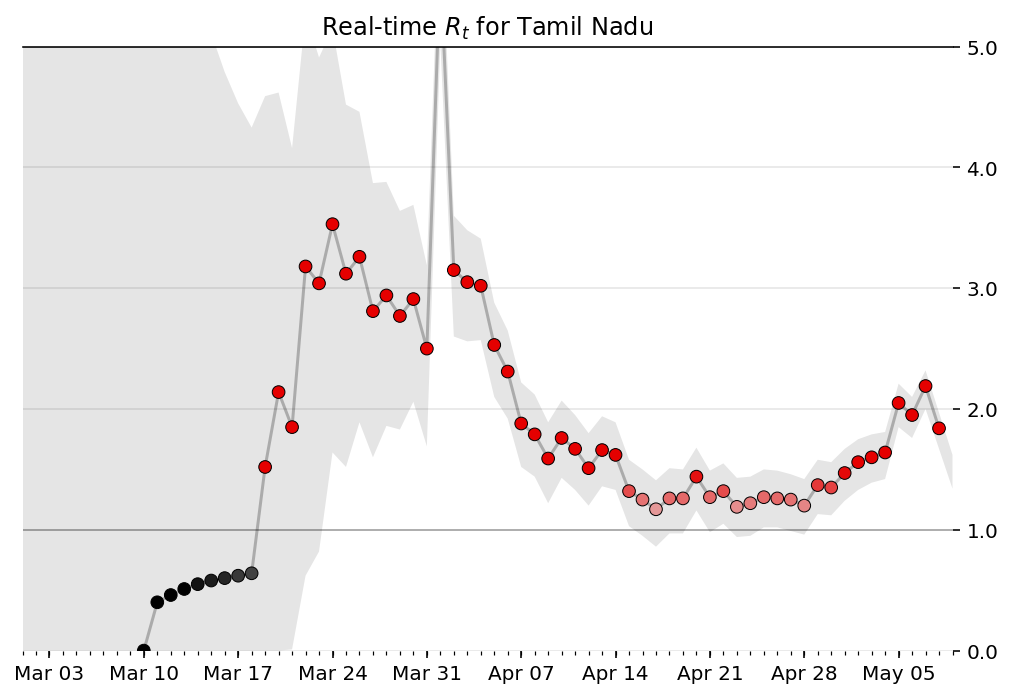

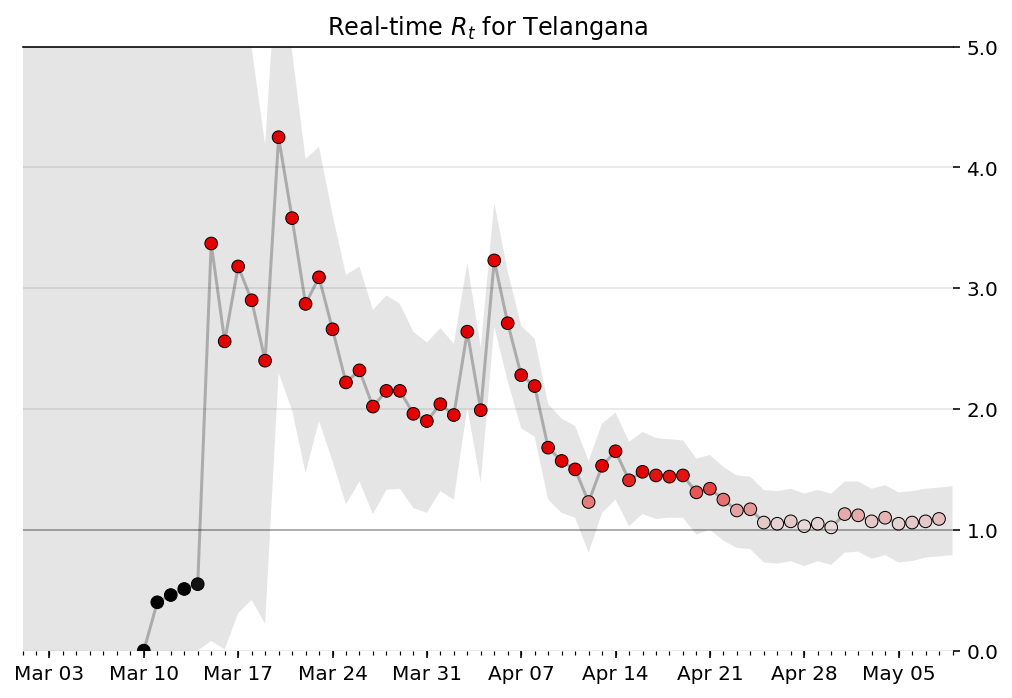

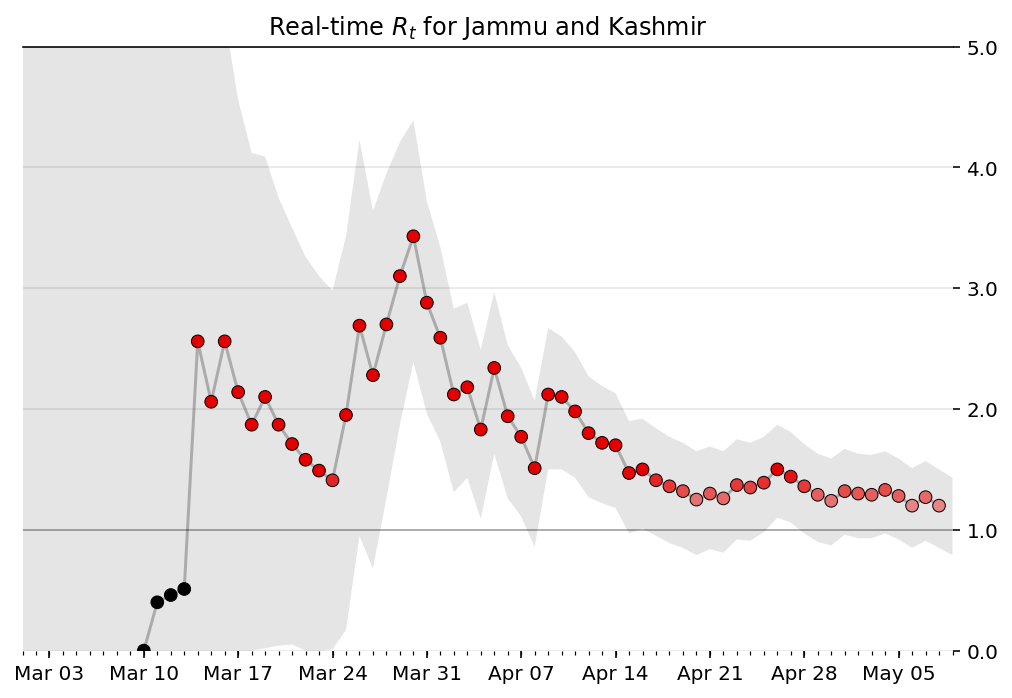

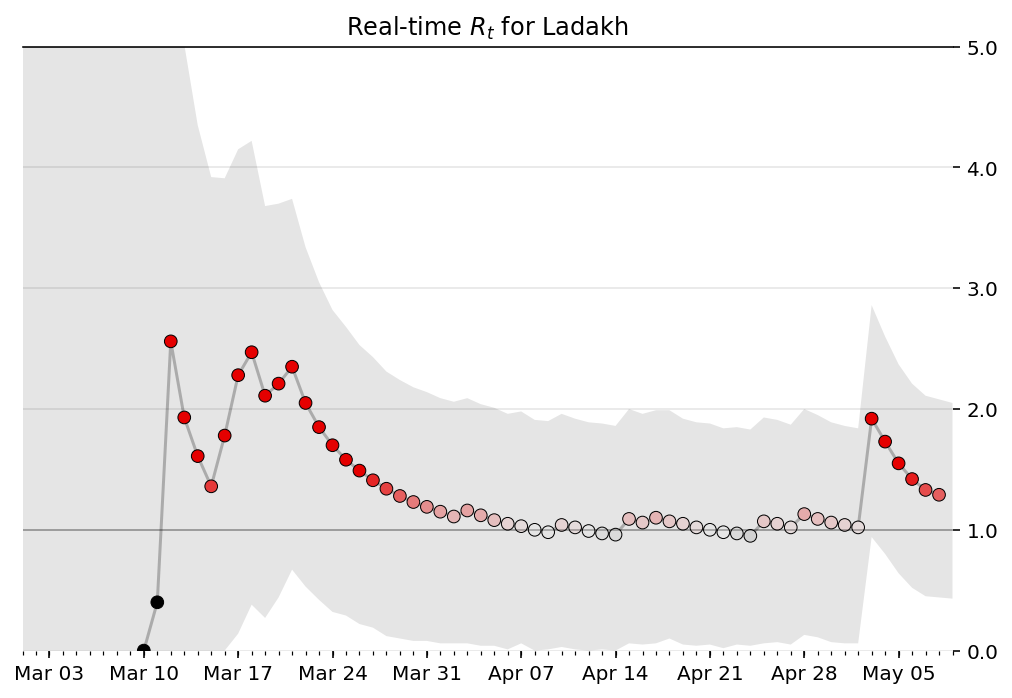

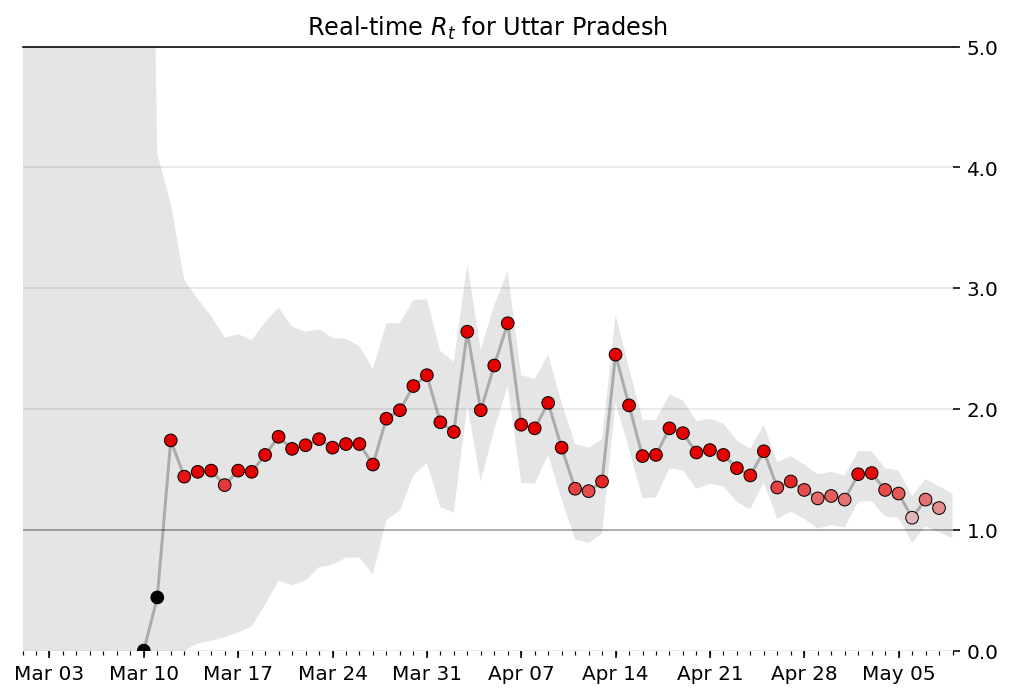

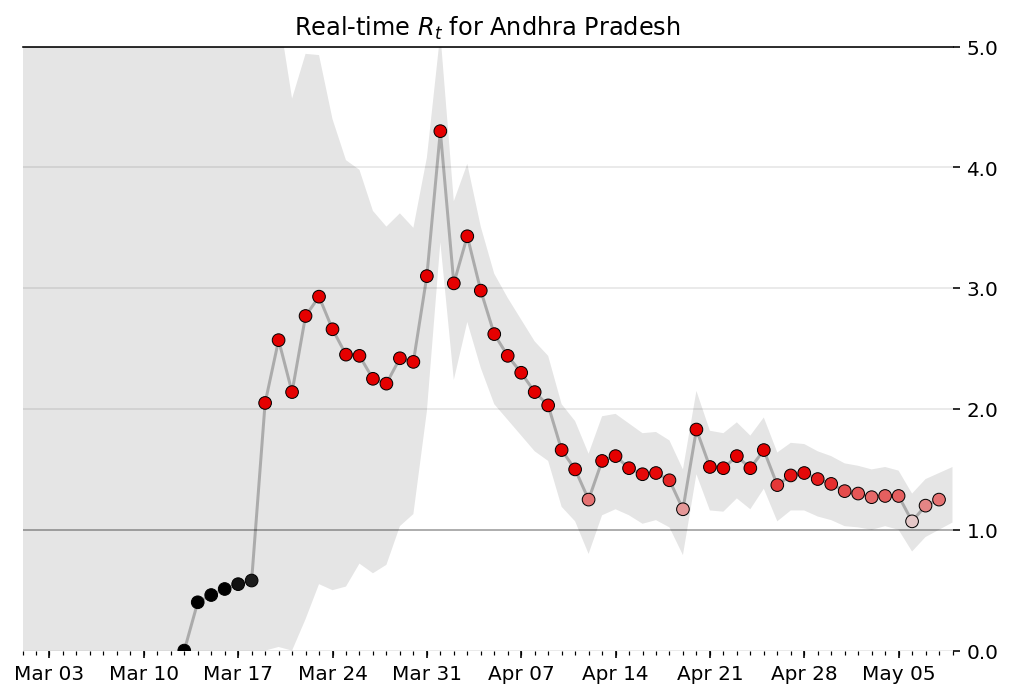

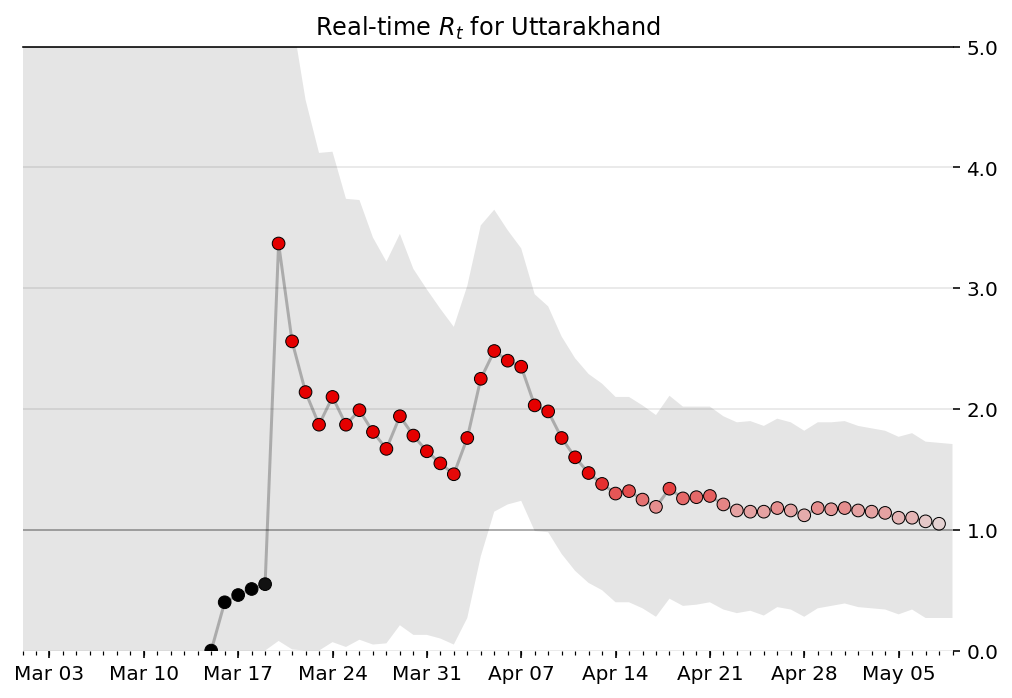

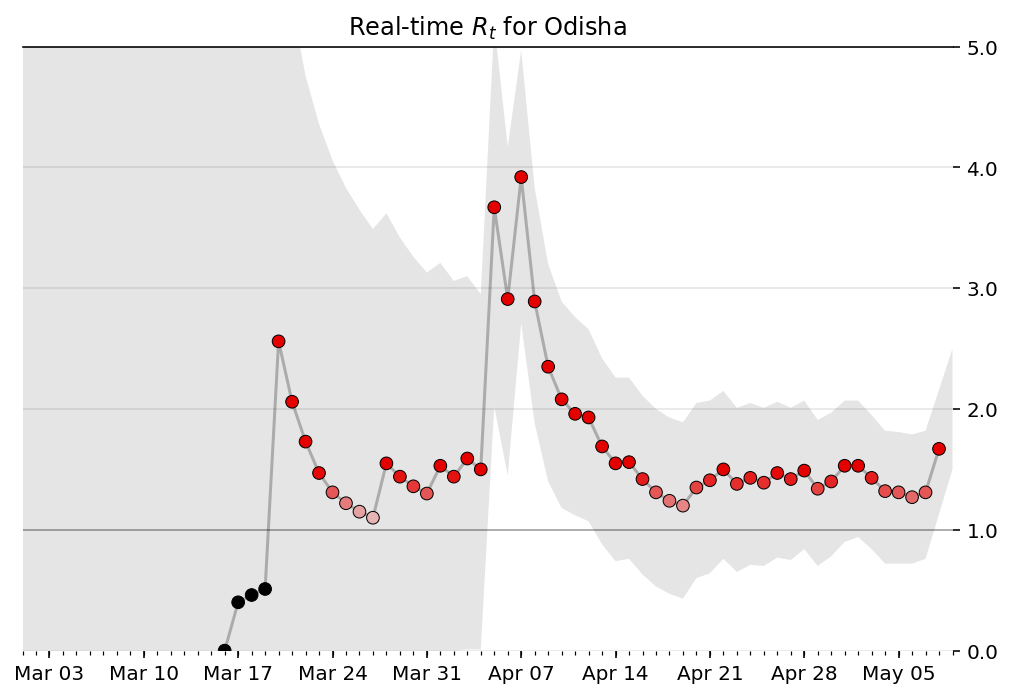

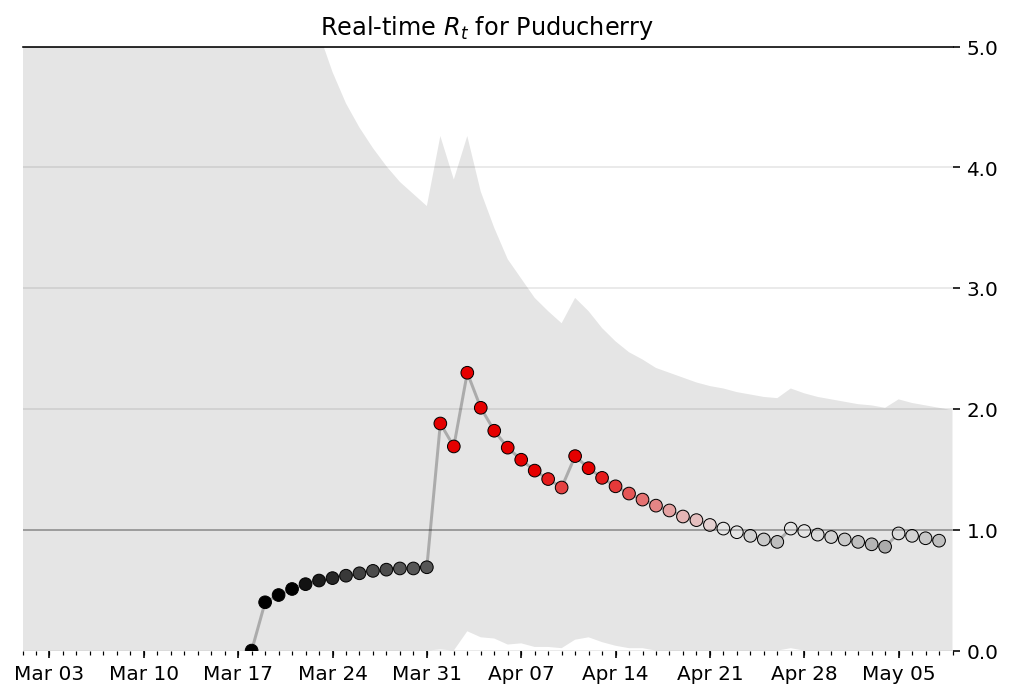

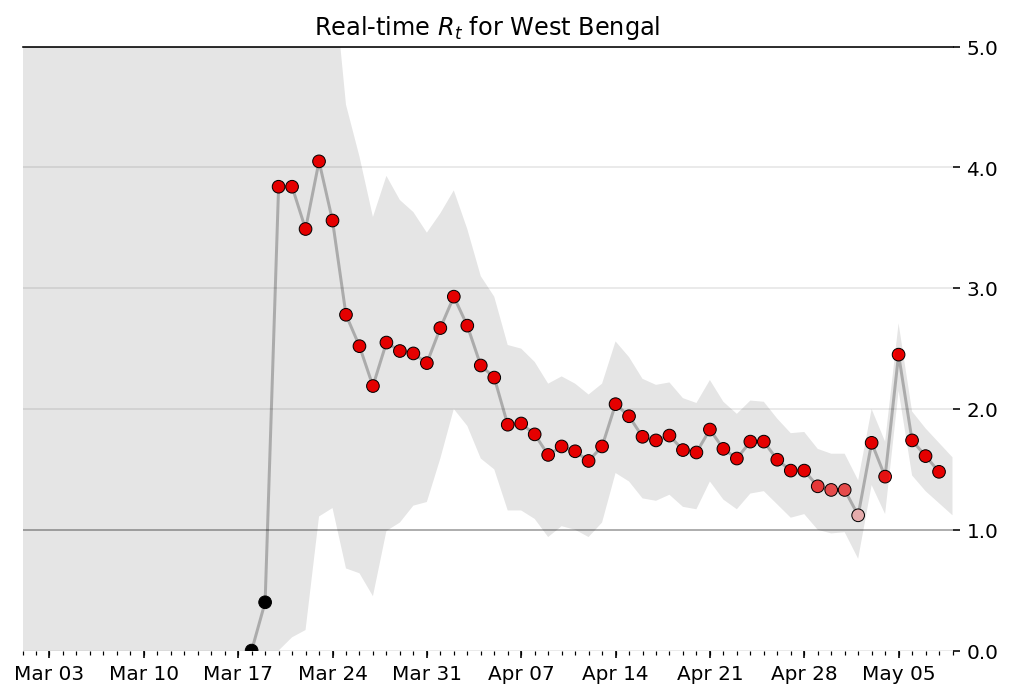

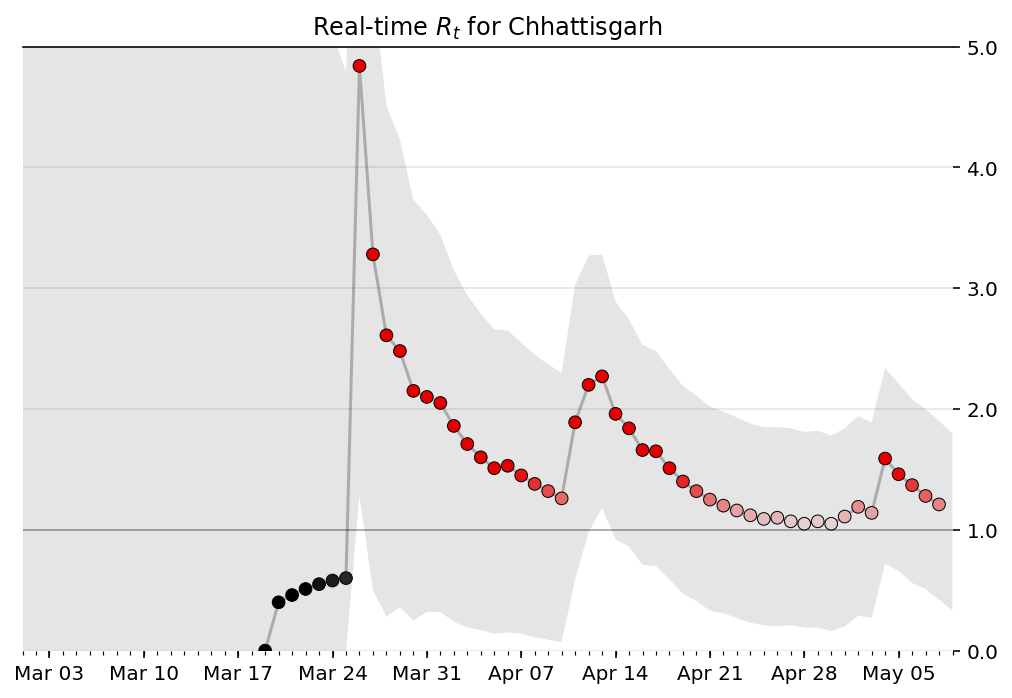

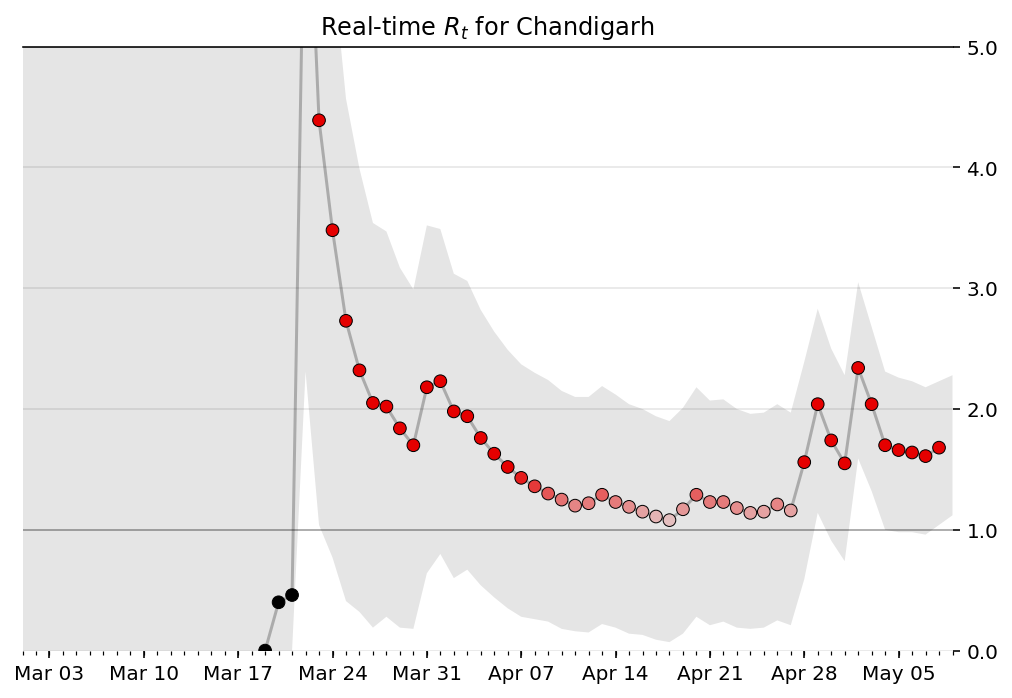

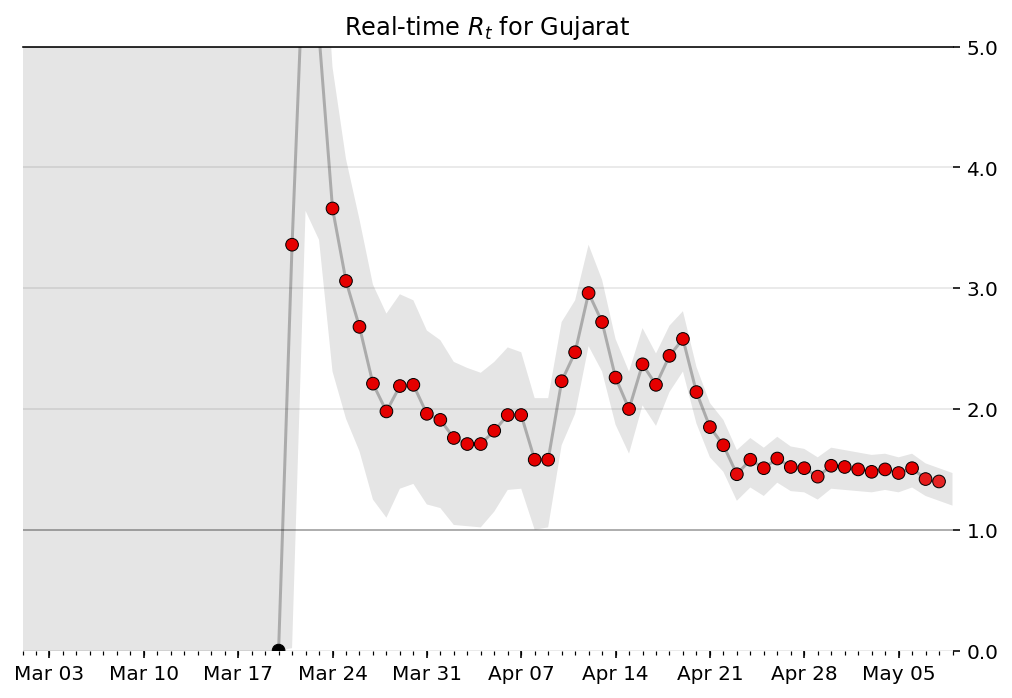

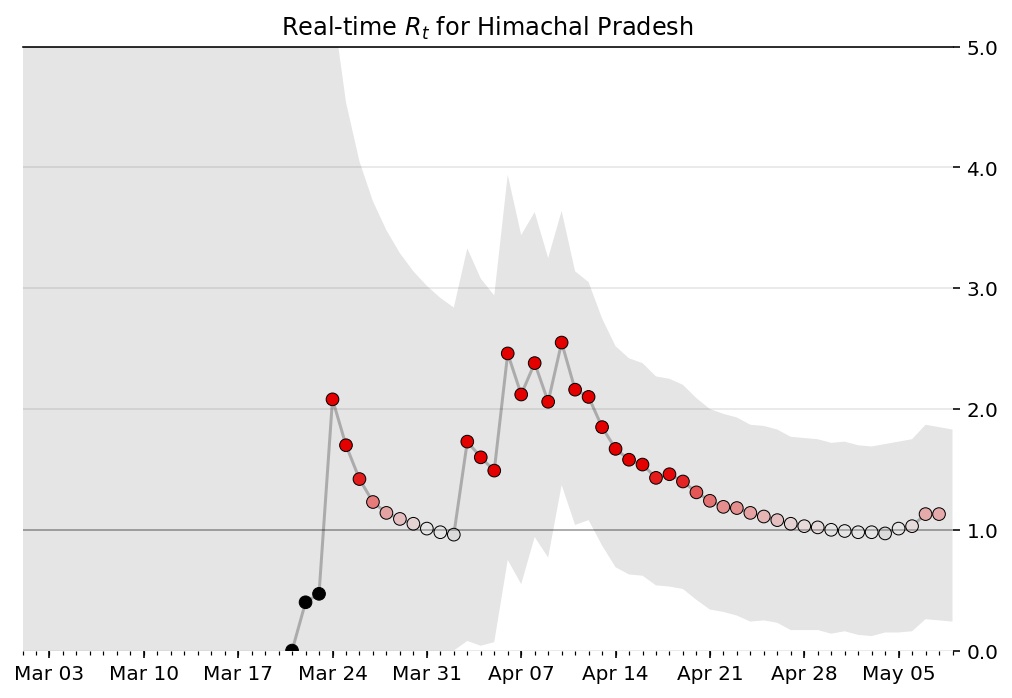

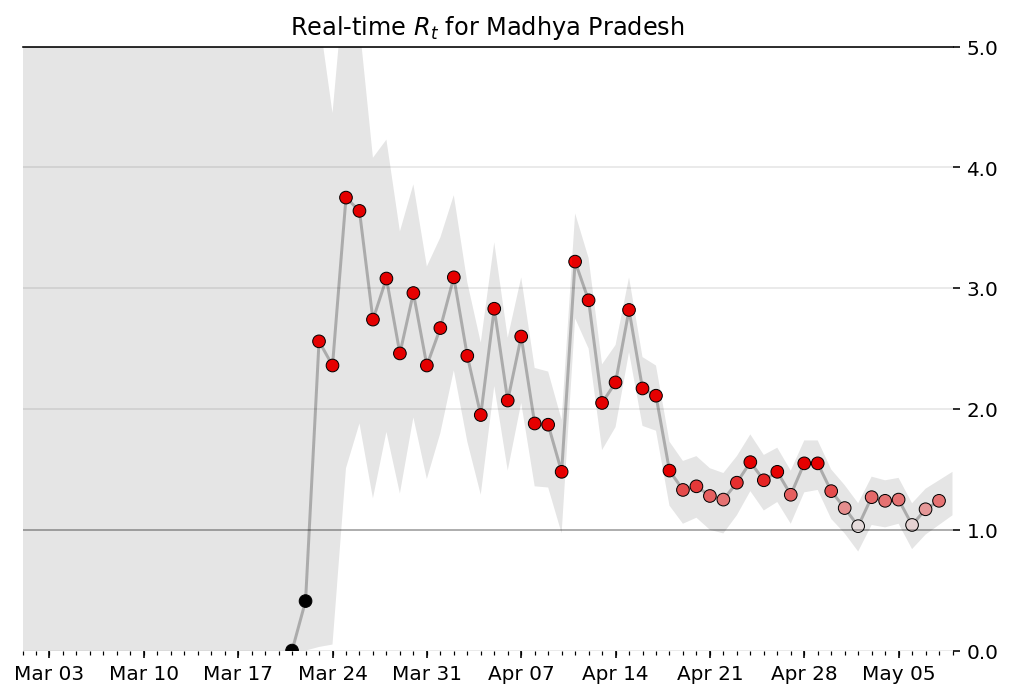

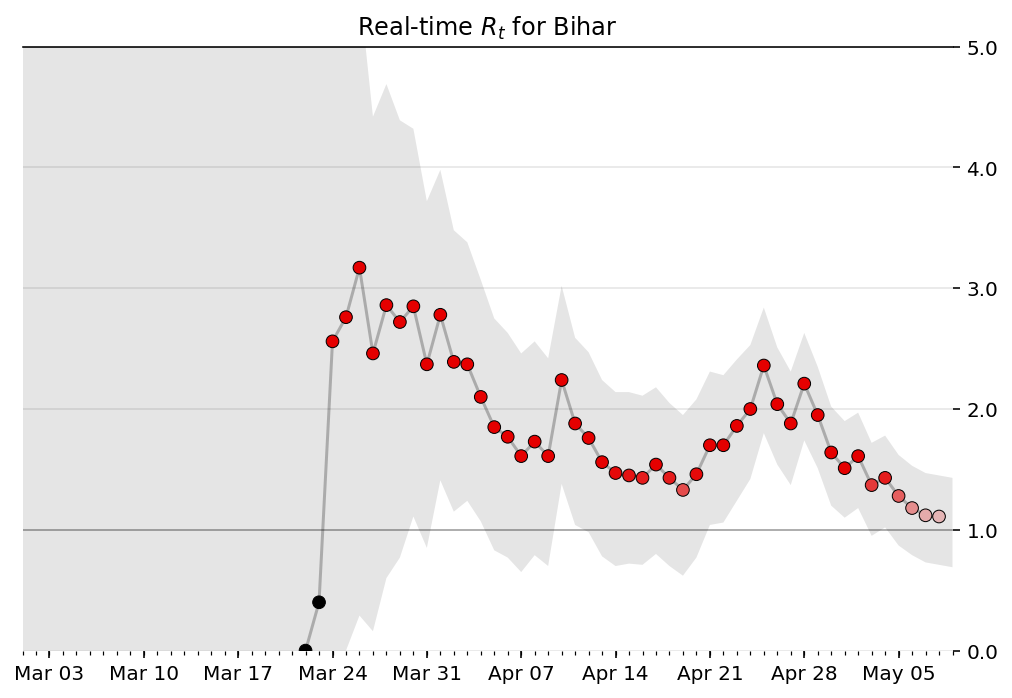

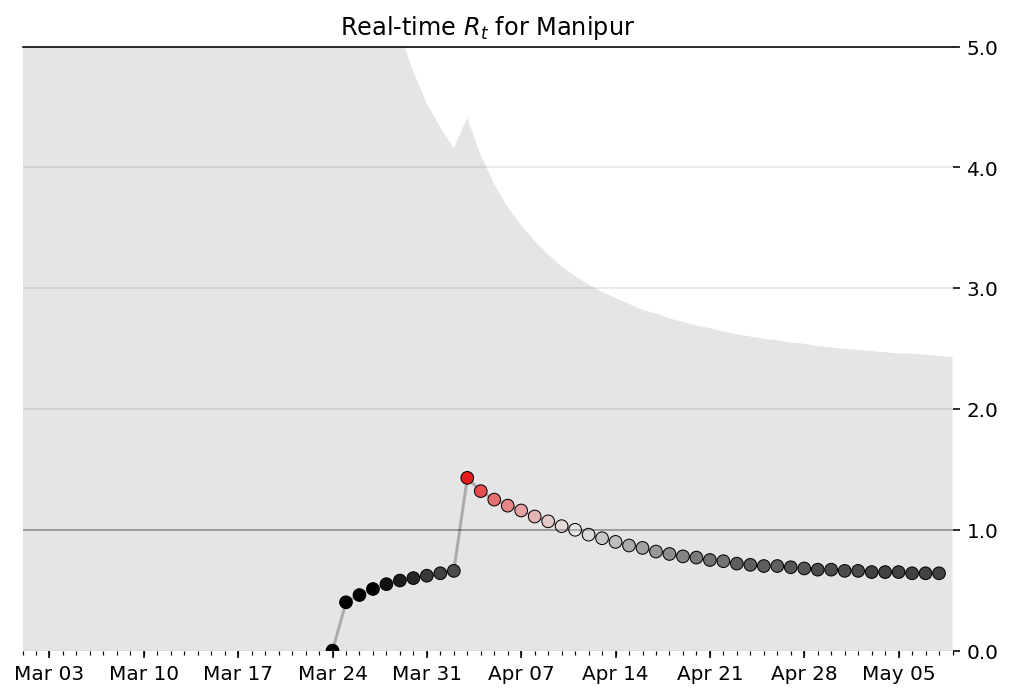

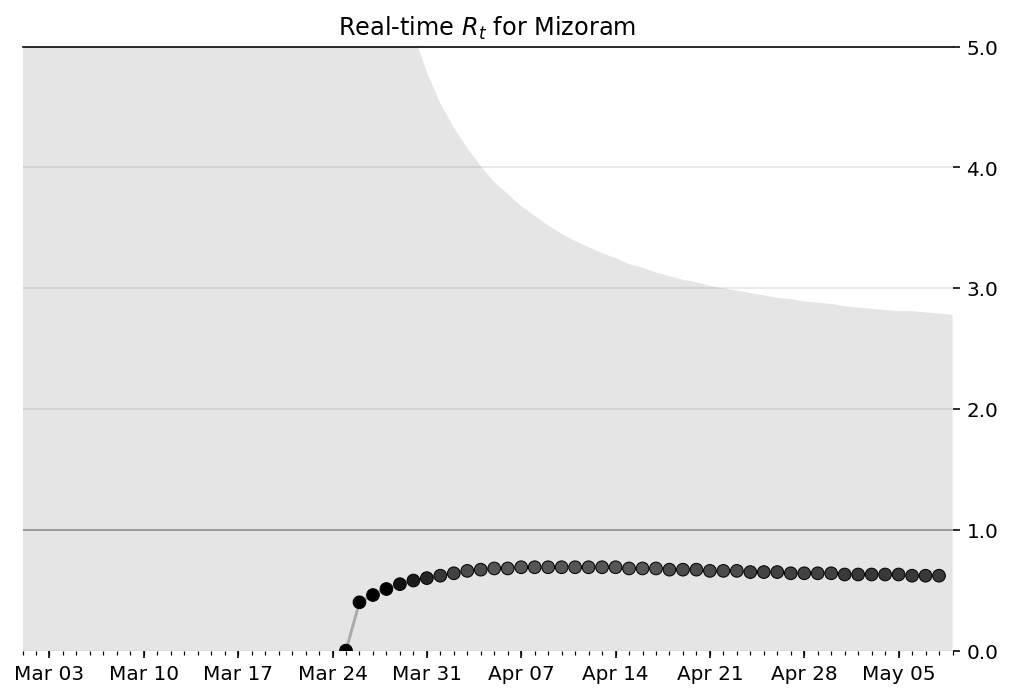

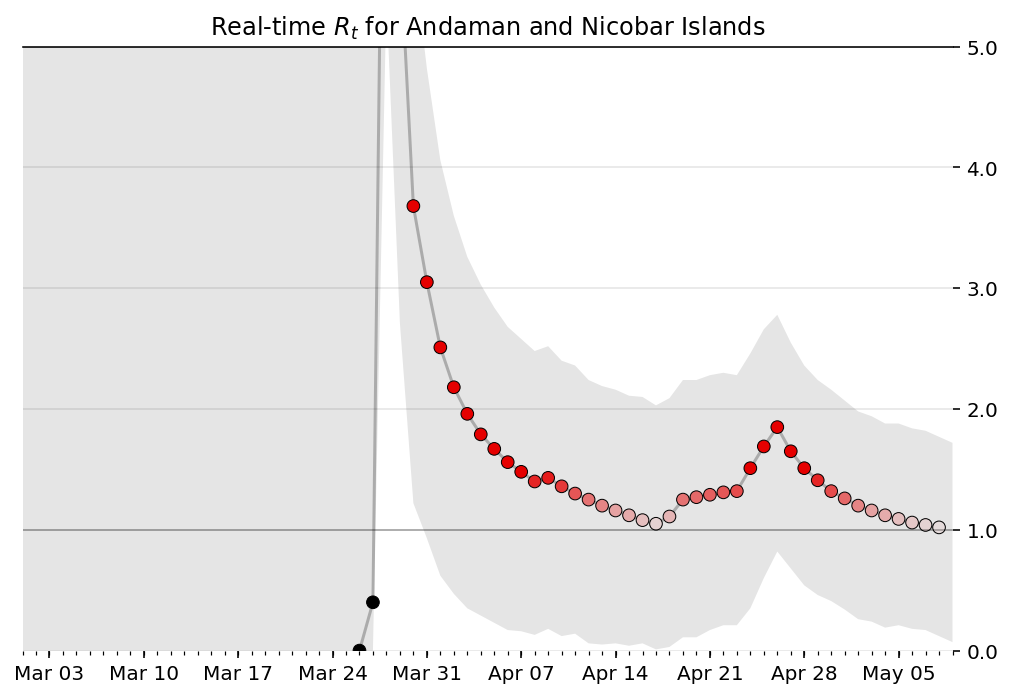

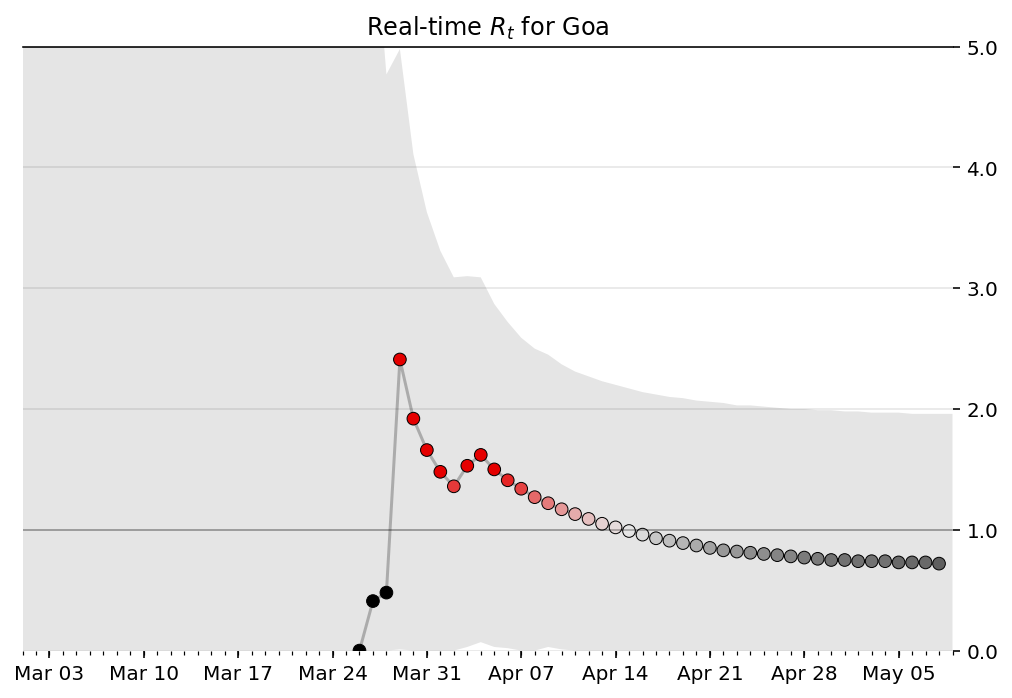

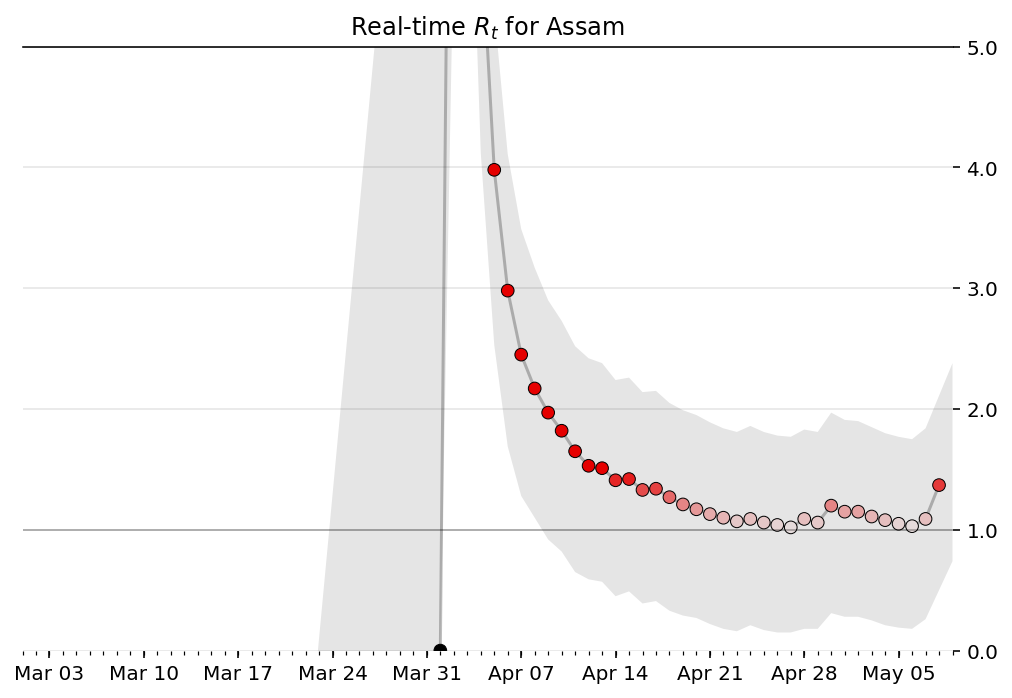

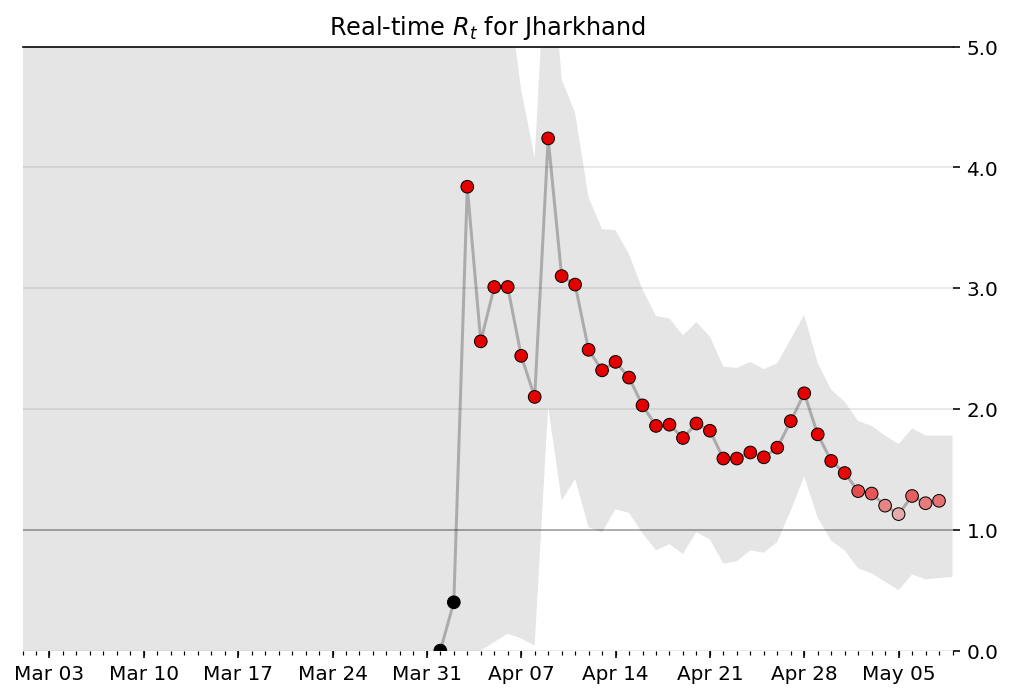

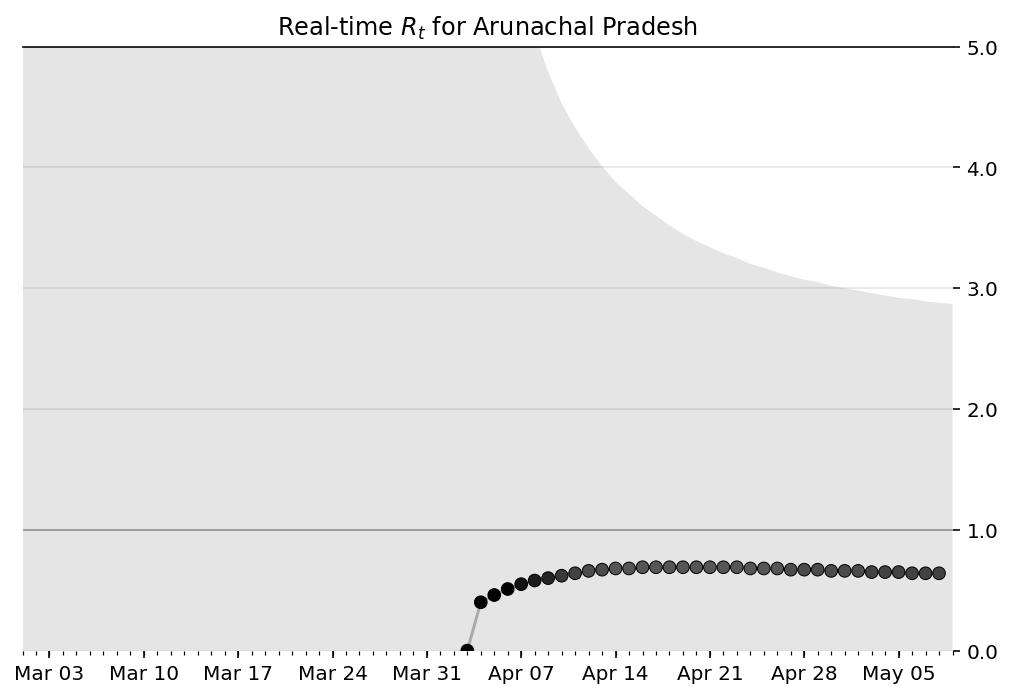

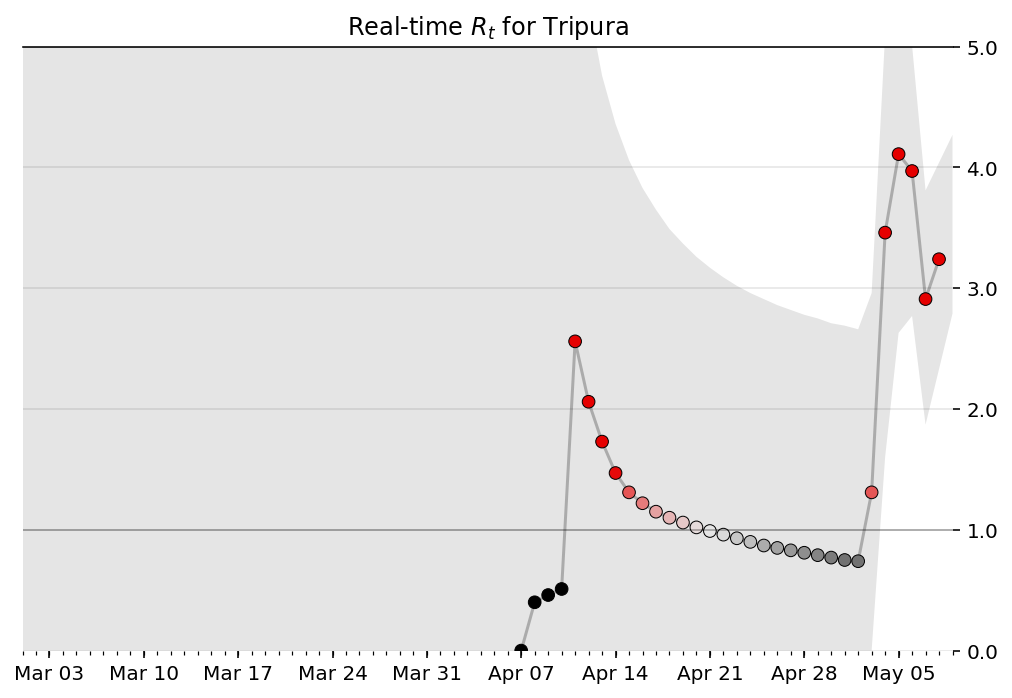

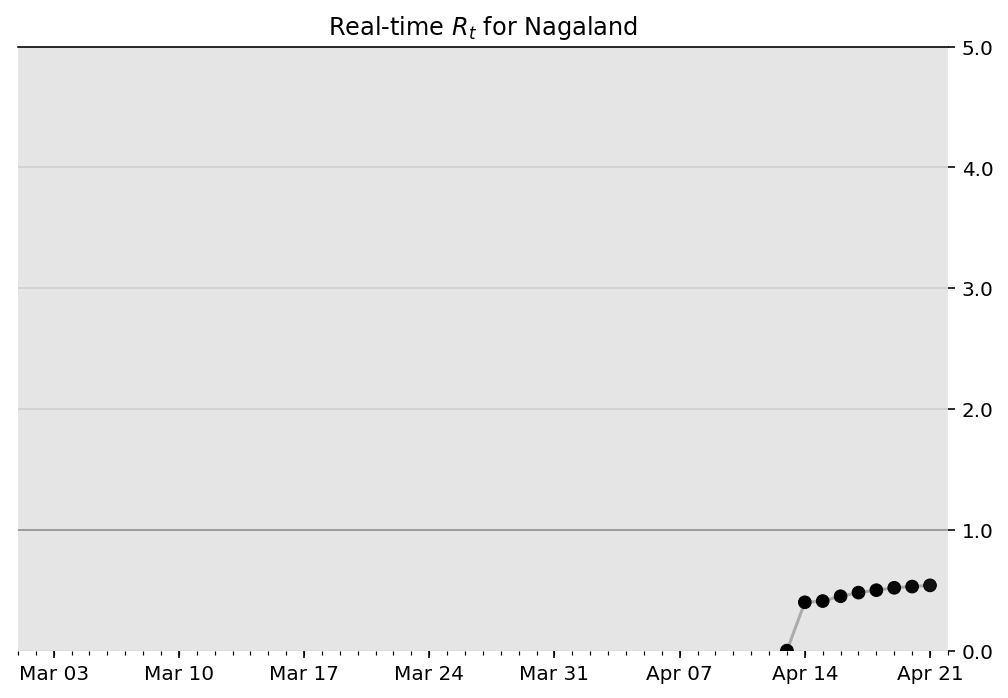

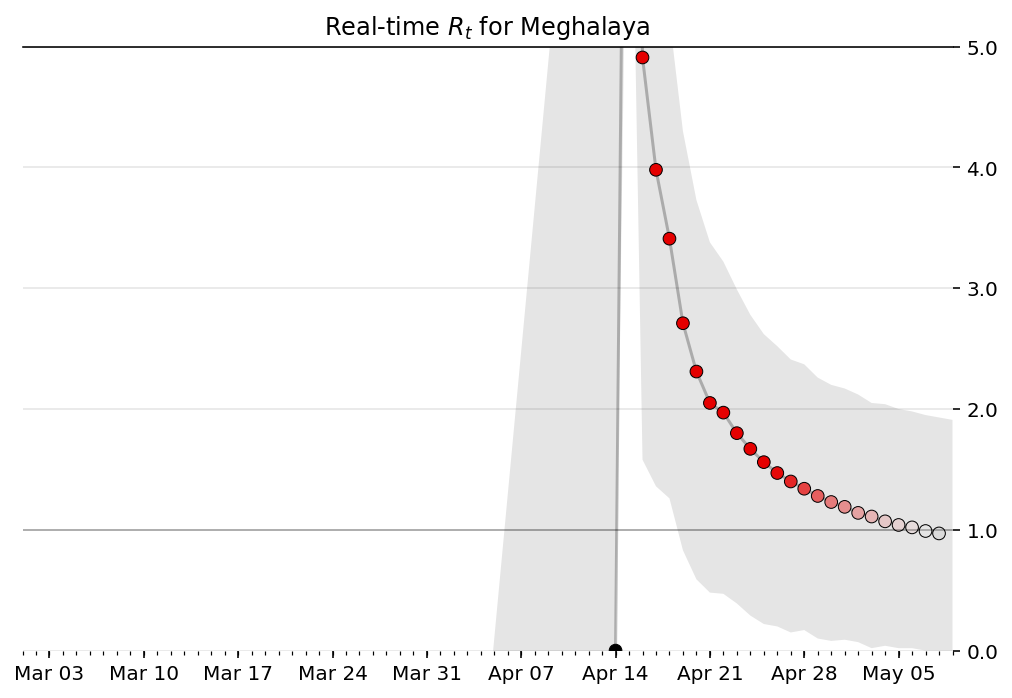

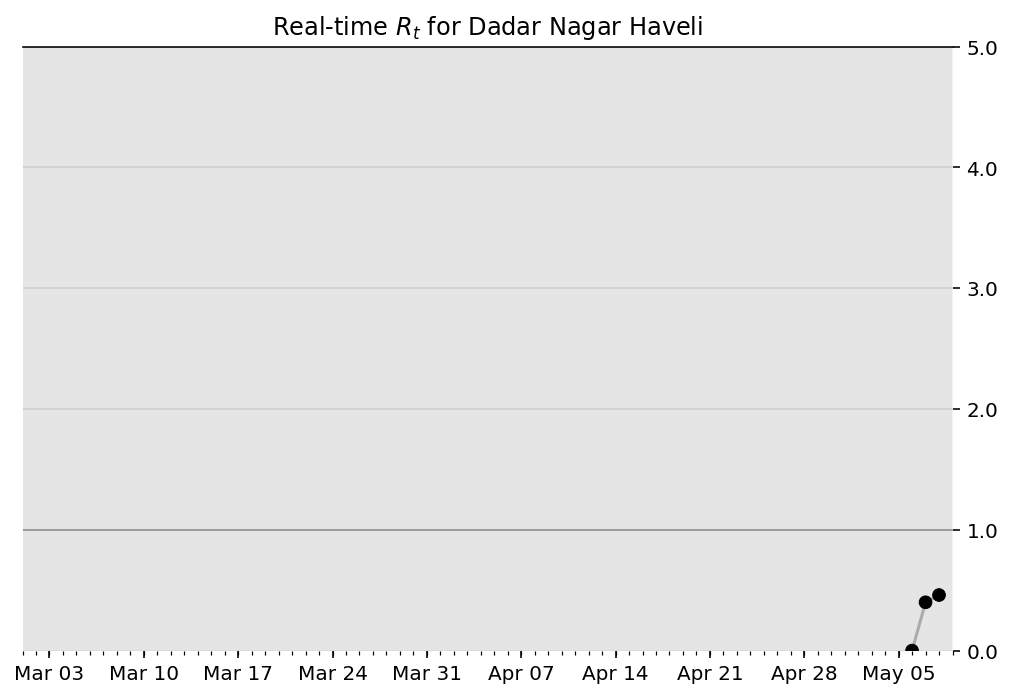

In [32]:
for i in df_statewise_timeseries['state'].unique():
    r = getR0(i)

### From the plots, we can that as we get more data, the range between Max and Min Rt becomes narrow and begins to coincide with the Most Likely Rt plot

### We can see that states such as Maharashtra, Tamil Nadu and Delhi which are having higher values of Rt are the states where more cases are being reported on a daily basis. The situation is still critical in these states

### Meanwhile we can see that the values of Rt in Karnataka and Kerala especially have stabilized at 1. In the real world too these states are the ones which are able to combat the virus better than the rest